# Reinforcement Learning: Using "Deep" Policy Gradient

This uses a (possibly deep) neural network to turn the image of a grid-world (maybe a maze) into action probabilities.

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 8, Homework (this is discussed in session 9)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use neural-network-based policy gradient reinforcement learning

It is an improvement of the tutorial code used in session 8.

Changes:

- The code has been restructured in terms of a class (object-oriented programming). That makes it more convenient to keep track of variables (e.g. to continue training, without using global variables).
- The network now tries to predict an action map, where the probabilities for all directions are listed as a function of position (and yet, this is only evaluated at the current position). That means we can purely use convolutional networks, and it seems to work much better. This is the main conceptual change (thanks to a suggestion by Thomas Fösel)
- visualization: this is better now. It also displays the trajectories inside the current batch, ordered according to return.

In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

from IPython.display import clear_output
from time import sleep

## Now: policy gradient

$$\delta\theta = \eta R \sum_{s,a} {\partial \over \partial \theta} \ln \pi_{\theta}(s,a)$$

Here $\theta$ stands for the parameters controlling the policy probabilities $\pi_{\theta}(s,a)$, s is the state, a the action, and the sum runs over all state-action pairs that were encountered in the given trajectory, which led to an overall return (sum of rewards) R.

Now $\pi_{\theta}(s,a)$ will be produced by a neural network. The state s (which is the input to the neural network) will be a picture of the maze (including the location of the chests and the location of the robot, in different channels). The actions a are just the four directions, as usual, and therefore the output of the neural network has four neurons (and the last layer should be softmax, to make sure these four neurons represent a probability distribution).  Note: In the new version, the output can also be chosen to be a map of such action probabilities (as noted above).

To implement the policy gradient update, as explained in the lecture, one just needs to use categorical cross-entropy as the cost function, and provide as the 'correct' answer for each time step: (0,R,0,0), where the return R for the full trajectory is inserted at the location of the action (=direction) actually taken in this time step. This will re-inforce that action, according to the return.


## The deep policy gradient algorithm: 'fast' version (trains in parallel on many mazes, which  accelerates the policy network evaluation, since this can be done on a whole batch of input images)


In [2]:
class MazeRL():
    # an empty playground... (even that turns out to be difficult enough currently)
    def empty_maze(self,width,height):
        """
        Generate an empty "maze" (just a wall around a free field)
        """
        mymaze=np.zeros([width,height],dtype='int')
        mymaze[:,0]=1
        mymaze[:,-1]=1
        mymaze[0,:]=1
        mymaze[-1,:]=1
        return(mymaze)

    # Maze generation algorithm from wikipedia
    # the code was removed in January 2020, but you can still
    # access it under this link:
    # https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705

    def maze(self,width=81, height=51, complexity=.75, density=.75):
        """
        Generate a maze. Algorithm taken from wikipedia.
        https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705
        """
        # Only odd shapes
        shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
        # Adjust complexity and density relative to maze size
        complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
        density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
        # Build actual maze
        Z = np.zeros(shape, dtype=bool)
        # Fill borders
        Z[0, :] = Z[-1, :] = 1
        Z[:, 0] = Z[:, -1] = 1
        # Make aisles
        for i in range(density):
            x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2 # pick a random position
            Z[y, x] = 1
            for j in range(complexity):
                neighbours = []
                if x > 1:             neighbours.append((y, x - 2))
                if x < shape[1] - 2:  neighbours.append((y, x + 2))
                if y > 1:             neighbours.append((y - 2, x))
                if y < shape[0] - 2:  neighbours.append((y + 2, x))
                if len(neighbours):
                    y_,x_ = neighbours[np.random.randint(0, len(neighbours) - 1)]
                    if Z[y_, x_] == 0:
                        Z[y_, x_] = 1
                        Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                        x, y = x_, y_
        return Z


    def setup(self,M=7,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=50,test_batchsize=5,
          nsteps=15,
          choose_random_positions_for_single_maze=False,
          place_chest=None,
          empty_maze=False,keep_maze=False,
          punish_wall_hit=0.5,
          train_for_action_map=False):
        """
        Setup everything in advance of running one or several
        trainings. The maze size M must be odd.
        You could re-run this to change some options like
        batchsize or even nsteps (number of time steps) and
        then continue training the same network.
        """
        if M%2==0:
            raise ValueError("Maze size must be odd, but was M="+str(M))

        # the five directions of motion [delta_jx,delta_jy]:
        self.directions=np.array([[1,0],[0,-1],[0,1],[-1,0],[0,0]])
        
        # keep all the global options that have been set
        self.M=M
        self.num_chests=num_chests
        self.delete_treasure=delete_treasure
        self.single_maze=single_maze
        self.batchsize=batchsize
        self.test_batchsize=test_batchsize
        self.nsteps=nsteps
        self.num_actions=len(self.directions)
        self.choose_random_positions_for_single_maze=choose_random_positions_for_single_maze
        self.place_chest=place_chest
        self.empty_maze=empty_maze
        self.punish_wall_hit=punish_wall_hit
        self.train_for_action_map=train_for_action_map
        
        # storing all the actions of the current trajectory
        self.actions=np.zeros([batchsize,nsteps], dtype='int')
        self.position=np.zeros([batchsize,nsteps,2], dtype='int')

        # same for test batch (which is smaller):
        self.test_actions=np.zeros([test_batchsize,nsteps], dtype='int')
        self.test_position=np.zeros([test_batchsize,nsteps,2], dtype='int')

        # we need to store all the input images
        # for a whole trajectory, for convenience
        # so we can afterwards make the training step 
        # on this set of images as one batch!
        self.input_images=np.zeros([batchsize,nsteps,M,M,3],dtype='float')
        self.test_input_images=np.zeros([test_batchsize,nsteps,M,M,3],dtype='float')

        # the current position, for all samples of the batch in parallel:
        self.jx,self.jy=np.zeros([batchsize],dtype='int'),np.zeros([batchsize],dtype='int')
        self.test_jx,self.test_jy=np.zeros([test_batchsize],dtype='int'),np.zeros([test_batchsize],dtype='int')

        if not keep_maze:
            # the maze maps, for all samples in parallel:
            self.world=np.zeros([batchsize,M,M],dtype='int')
            self.test_world=np.zeros([test_batchsize,M,M],dtype='int')

        # store cost function for the training step (out of curiosity)
        self.costs=None # will be initialized in run

        # useful for some advanced array indexing:
        self.allsamples=np.arange(0,batchsize)
        self.test_allsamples=np.arange(0,test_batchsize)

        # generate test mazes on which the strategy will be
        # repeatedly illustrated:
        if not keep_maze:
            self.test_reward,self.test_input_image=self.prepare_batch(batchsize=test_batchsize,
                                            world=self.test_world,jx=self.test_jx,jy=self.test_jy)

        # special case: a single maze (not a fresh maze for every sample)
        if not keep_maze:
            if single_maze:
                if place_chest is not None:
                    self.test_reward[0,:,:]=0
                    self.test_reward[0,place_chest[0],place_chest[1]]=1.0

                for n in range(1,test_batchsize):
                    self.test_reward[n,:,:]=self.test_reward[0,:,:]
                    self.test_input_image[n,:,:,:]=self.test_input_image[0,:,:,:]
                    self.test_world[n,:,:]=self.test_world[0,:,:]
                self.reward,self.input_image=self.prepare_batch(batchsize=batchsize,
                                                world=self.world,jx=self.jx,jy=self.jy)
                for n in range(batchsize):
                    self.reward[n,:,:]=self.test_reward[0,:,:]
                    self.input_image[n,:,:,:]=self.test_input_image[0,:,:,:]
                    self.world[n,:,:]=self.test_world[0,:,:]
            w=np.where(self.test_reward[0,:,:]>0.5)
            self.chest_x=w[0][0] # position of (first) treasure chest
            self.chest_y=w[1][0]
        
        self.orig_test_world=np.copy(self.test_world)
        self.orig_test_reward=np.copy(self.test_reward)

        
    def compile_net(self,eta=0.0001,try_adam=False):
        """
        Compile the network. You could re-compile this
        with a different learning rate.
        """
        # we have to use categorical cross entropy for the
        # policy gradient update rule!
        # also, we should not use adam (which tries to be adaptive),
        # but just plain old simple stochastic gradient descent,
        # if we want the policy gradient update to be correctly
        # implemented!
        if try_adam:
            self.Policy.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.Adam(learning_rate=eta))
        else:
            self.Policy.compile(loss='categorical_crossentropy',
                           optimizer=optimizers.SGD(learning_rate=eta,clipnorm=1.0))


    def create_network(self):             
        # first define the policy neural network
        self.Policy=Sequential()
        self.Policy.add(Conv2D(self.num_channels,
                               kernel_size=self.kernel_size,
                               input_shape=(self.M,self.M,3),
                        activation="elu",padding="same"))
        self.Policy.add(Conv2D(self.num_channels,kernel_size=self.kernel_size,
                        activation="elu",padding="same"))
        self.Policy.add(Conv2D(self.num_channels,kernel_size=self.kernel_size,
                        activation="elu",padding="same"))
        self.Policy.add(Conv2D(self.num_channels,kernel_size=self.kernel_size,
                        activation="elu",padding="same"))
        if not self.train_for_action_map:
            self.Policy.add(Flatten())
            self.Policy.add(Dense(self.num_actions,activation="softmax"))
        else:
            self.Policy.add(Conv2D(self.num_actions,kernel_size=self.kernel_size,
                                   activation="softmax",padding="same"))
        # the output layer with the probabilities
        
    def __init__(self,M=7,eta=0.0001,num_chests=1,delete_treasure=False,
          single_maze=True,batchsize=50,test_batchsize=5,
          nsteps=15,
          try_adam=False,choose_random_positions_for_single_maze=False,
          place_chest=None,kernel_size=5,num_channels=5,
          empty_maze=False,punish_wall_hit=0.5,
           train_for_action_map=False, extra_visualizer=None):
        """
        Initialize a neural network for the policy gradient applied to
        arbitrary mazes. This also initializes all kinds of global variables
        that will be needed for the training.
        
        See also: setup (which will be called from here).
        
        If you called this like mymaze=MazeRL(...), then afterwards
        the network will be available as mymaze.Policy. You could change
        that to replace it by your own hand-crafted network (do that
        before starting training).
        """

        self.try_adam=try_adam
        self.kernel_size=kernel_size
        self.num_channels=num_channels
        self.extra_visualizer=extra_visualizer
        
        # the setup
        self.setup(M=M,num_chests=num_chests,delete_treasure=delete_treasure,
              single_maze=single_maze,batchsize=batchsize,test_batchsize=test_batchsize,
              nsteps=nsteps,
              choose_random_positions_for_single_maze=choose_random_positions_for_single_maze,
              place_chest=place_chest,
              empty_maze=empty_maze,punish_wall_hit=punish_wall_hit,
                  train_for_action_map=train_for_action_map)
        
        self.create_network()

        self.compile_net(eta=eta,try_adam=try_adam)




    def prepare_batch(self,batchsize,world,jx,jy):
        """
        prepare one batch, return:
            reward,input_image
        Arrays world and jx,jy need already to exist, but will
        be filled with values.
        """
        
        M=self.M
        empty_maze=self.empty_maze
        
        # a map of rewards (the 'chests' are here!)
        reward=np.zeros([batchsize,M,M],dtype='float')

        for sample in range(batchsize):
            # make a new maze (a new one in each trial!)
            if not empty_maze:
                world[sample,:,:]=np.array(self.maze(width=M,height=M),dtype='int')            
            else:
                world[sample,:,:]=np.array(self.empty_maze(width=M,height=M),dtype='int')
            # random selection of reward sites (treasure chests)
            for n in range(self.num_chests): 
                while True:
                    jx_target,jy_target=np.random.randint(low=2,high=M-2,size=2)  # avoid close to boundary!
                    if world[sample,jx_target,jy_target]==0: # empty, keep it!
                        reward[sample,jx_target,jy_target]+=1
                        break

        # pick random initial position:
        for sample in range(batchsize):
            while True:
                jx_try,jy_try=np.random.randint(low=2,high=M-2,size=2) # avoid close to boundary!
                if world[sample,jx_try,jy_try]==0:
                    jx[sample],jy[sample]=jx_try,jy_try
                    break

        # prepare an input image for the network
        input_image=np.zeros([batchsize,M,M,3],dtype='float')
        input_image[:,:,:,0]=world 
        # we can set this now, since it will not change during this trial

        return(reward,input_image)


    def run_one_trial(self,input_image,
                     input_images,
                     reward, jx, jy,
                     actions,position,world,
                            allsamples,batchsize):
        """
        Run one trial starting at position jx,jy, storing returns in R, storing
        actions and position, using input_image and world.
        This will return R.
        """    
        # set return to zero for this trajectory:
        R=np.zeros([self.batchsize])

        # go through all time steps
        for t in range(self.nsteps):
            # Obtain the policy prediction given the current
            # situation:
            # the maze map is already stored
            # inside input_image[0,:,:,0]
            # but the treasure map and
            # the robot position need to be updated
            input_image[:,:,:,1]=reward # current treasure map!
            input_image[self.allsamples,jx,jy,2]=1 
            # last line indicates position of robot(s)! (for whole batch)
            # note: this uses advanced numpy indexing, so we use
            # three equal-length integer arrays a,b,c to do the
            # equivalent of
            #  for k in range(n):
            #      input_image[a[k],b[k],c[k],2]=1
            #
            # now: evaluate policy network on the whole batch:
            # this is where we gain efficiency!
            policy_p=self.Policy.predict_on_batch(input_image)

            if self.train_for_action_map:
                policy_p=policy_p[self.allsamples,jx,jy,:]
            
            #print(policy_p)
            if np.any(policy_p>1.001):
                print("Oops, policy out of range:",policy_p)

            # now policy_p is an array of [batchsize,4] probabilities

            # make a random step, according to the policy distribution
            p=np.random.uniform(size=batchsize)
            cumulative_distribution=np.cumsum(policy_p,axis=1) # note axis argument
            pick=np.argmax(cumulative_distribution>p[:,None],axis=1) 
            # will give the index of the first entry that exceeds p, which is
            # exactly what we need (pick will still be a 1D array of 'batchsize' length)

            # record the move
            #print(pick[0],jx[0],jy[0])
            actions[:,t]=pick
            position[:,t,0]=jx
            position[:,t,1]=jy
            input_images[:,t,:,:,:]=np.copy(input_image) # store for later

            # now make the move
            jx_new,jy_new=jx+self.directions[pick][:,0],jy+self.directions[pick][:,1]

            # really make it if there is no wall:
            # again, we do this for all samples in parallel,
            # thanks to advanced numpy array indexing
            can_move=np.array(world[self.allsamples,jx_new,jy_new]==0,dtype='int') # 1 if can move
            input_image[self.allsamples,jx,jy,2]-=can_move # delete old position only if we can move
            jx,jy=jx*(1-can_move)+jx_new*can_move,jy*(1-can_move)+jy_new*can_move

            # get a reward if on a treasure chest!
            r=reward[self.allsamples,jx,jy] # will be array of batchsize length
            if self.delete_treasure:
                reward[self.allsamples,jx,jy]-=1*(r>0) # delete treasure!
                
            # punish a bit whenever we moved into a wall!
            r-=self.punish_wall_hit*(1-can_move)
            R+=r

        return(R)

    def run(self,ntrials=1000,skipsteps=20,do_visualize=True,
           do_show_test_batch=False,do_plot_trajectories=True,
           P_cmap='viridis'):
        """
        Run the policy gradient training for 'ntrials' training
        trials, each containing a number of trajectories given
        by 'batchsize' (as initialized when first creating the
        MazeRL object; you can reset that using 'setup').
        
        Visualize every skipsteps steps.
        
        Every call to this method trains further, and it does not
        delete the old stored cost values, so it keeps displaying
        the overall progress in training from the start.
        """
        self.P_cmap=P_cmap
        
        if self.costs is not None:
            self.costs=np.append(self.costs,np.zeros(ntrials))
            self.Returns=np.append(self.Returns,np.zeros([self.batchsize,ntrials]),axis=1)
        else:
            self.costs=np.zeros(ntrials)
            self.Returns=np.zeros([self.batchsize,ntrials])        

        # try many trajectories:
        for trial in range(ntrials):
            # prepare the mazes of the batch (and starting positions, and treasure distribution):
            if not self.single_maze: # generate a fresh maze for every sample in the batch
                self.reward,self.input_image=self.prepare_batch(batchsize=self.batchsize,
                                            world=self.world,jx=self.jx,jy=self.jy)
            else: # keep the one single maze
                for sample in range(self.batchsize):
                    self.jx[sample],self.jy[sample]=1,1
                    self.input_image[sample,:,:,2]=0
                    self.input_image[sample,self.jx[sample],self.jy[sample],2]=1
           # the following good for starting from random positions, but the same maze
                    if self.choose_random_positions_for_single_maze:
                        while True:
                            jx_try,jy_try=np.random.randint(self.M,size=2)
                            jx_try,jy_try=np.random.randint(self.M,size=2)
                            if self.world[sample,jx_try,jy_try]==0:
                                self.jx[sample],self.jy[sample]=jx_try,jy_try
                                self.input_image[sample,:,:,2]=0
                                self.input_image[sample,self.jx[sample],self.jy[sample],2]=1 # place robot
                                break        

            # run a single full trial
            # as usual, all arrays are passed by reference and will be filled
            # with new values in this routine
            self.R=self.run_one_trial(input_image=self.input_image,
                     input_images=self.input_images,
                     reward=self.reward, jx=self.jx, jy=self.jy,
                     actions=self.actions,position=self.position,world=self.world,
                            allsamples=self.allsamples,batchsize=self.batchsize)

            # store the return
            self.Returns[:,-(ntrials-trial)]=self.R

            # use policy gradient update rule to adjust
            # probabilities!
            # first: make an array for the target policy distributions
            # for all time steps (those that contain 'R' in the slot
            # of the action that was actually taken!)
            if not self.train_for_action_map:
                self.target_distributions=np.zeros([self.batchsize,self.nsteps,self.num_actions])
                for t in range(self.nsteps): # go through the trajectory again
                    a=self.actions[:,t] # remember the action taken at step t
                    self.target_distributions[self.allsamples,t,a]=self.R # reinforce that action!
                self.costs[trial]=self.Policy.train_on_batch(np.reshape(self.input_images,[self.batchsize*self.nsteps,self.M,self.M,3]),
                                                   np.reshape(self.target_distributions,[self.batchsize*self.nsteps,self.num_actions]))
            else:
                self.target_distributions=np.zeros([self.batchsize,self.nsteps,self.M,self.M,self.num_actions])
                for t in range(self.nsteps): # go through the trajectory again
                    a=self.actions[:,t] # remember the action taken at step t
                    self.target_distributions[self.allsamples,t,self.position[:,t,0],self.position[:,t,1],a]=self.R # reinforce that action!
                self.costs[trial]=self.Policy.train_on_batch(np.reshape(self.input_images,[self.batchsize*self.nsteps,self.M,self.M,3]),
                                                   np.reshape(self.target_distributions,[self.batchsize*self.nsteps,self.M,self.M,self.num_actions]))

                
            # we needed the reshape to make sure the input is still
            # of shape [total_batchsize,M,M,3]
            # ...only now total_batchsize is larger!
            # this will run through the update algorithm a larger number
            # of samples in parallel, which again is very efficient!

            # visualize!
            if do_visualize and trial%skipsteps==0 or trial==ntrials-1:
                self.visualize(do_show_test_batch)
                if do_plot_trajectories:
                    self.plot_trajectories()
                    
    def visualize(self,do_show_test_batch=False):
        """
        Visualize the current training status:
        Cost function and either of the two:
        performance on a batch of test samples (if do_show_test_batch
        was True) or policy as a function of position (otherwise)
        """
        if do_show_test_batch:
            current_test_reward=np.copy(self.test_reward) # avoid changes in the test_reward!
            R_test=self.run_one_trial(input_image=self.test_input_image,
                 input_images=self.test_input_images,
                 reward=self.current_test_reward, jx=self.test_jx, jy=self.test_jy,
                 actions=self.test_actions,position=self.test_position,
                world=self.test_world,allsamples=self.test_allsamples,
                batchsize=self.test_batchsize)

        clear_output(wait=True)
        fig=plt.figure(constrained_layout=True,
                       figsize=(self.num_actions,3))
        gs=fig.add_gridspec(ncols=self.num_actions,nrows=3)
        returns_plot=fig.add_subplot(gs[0:2,:])

        # show all the returns so far (averaged over the batch for each trial)
        returns_plot.plot(np.average(self.Returns,axis=0)) 
        # all the returns, in all trials (averaged over batch!)
        returns_plot.set_title("Return vs trial ("+str(self.batchsize)+" trajs/trial)")

        if do_show_test_batch:
            n_test_plots=self.test_batchsize
        else:
            n_test_plots=self.num_actions

        test_plot=[]
        for n in range(n_test_plots):
            test_plot.append(fig.add_subplot(gs[2,n]))

        if not do_show_test_batch:
            self.plot_try_pos(self.orig_test_world,self.orig_test_reward,
                         ax=test_plot,target=[self.chest_x,self.chest_y])
        else:
            # show what's happened in this test trial
            for n in range(self.test_batchsize):
                # draw the trajectory of current batch sample 0!
                picture=np.zeros([self.M,self.M,3]) # last index: red/green/blue
                picture[:,:,0]=self.test_world[n,:,:] # walls are red
                for j in range(self.nsteps): # highlight trajectory
                    picture[self.test_position[n,j,0],self.test_position[n,j,1],1]=0.5*(1.0+(1.0*j)/self.nsteps)
                # put a bright pixel at the positions visited
                # highlight the target sites!
                picture[:,:,2]+=1*(self.test_reward[n,:,:]>0)

                # show picture (transpose is needed because
                # otherwise the first coordinate jx is plotted upwards,
                # not to the right)
                test_plot[n].imshow(np.transpose(picture,[1,0,2]),origin='lower')
                test_plot[n].axis('off')
        plt.show()
        if self.extra_visualizer is not None:
            self.extra_visualizer(self) # call some extra user-defined routine

    def plot_trajectories(self,width=5):
        world=self.world
        reward=self.reward
        position=self.position
        R=self.R
        M=self.M
        indices=np.argsort(R)[::-1]
        height=int(len(R)/width)
        if height*width<len(R):
            height+=1
        fig,ax=plt.subplots(ncols=width,nrows=height,figsize=[width,height])
        mx=0; my=0
        for k in indices:
            ax[my,mx].imshow(np.transpose(world[k,:,:]+0.6*reward[k,:,:]),origin='lower')
#             ax[my,mx].plot(position[k,:,0],position[k,:,1],linewidth=3,color="orange")
            ax[my,mx].scatter(position[k,:,0],position[k,:,1],s=5,zorder=10,alpha=0.5)
            ax[my,mx].set_xlim(-1,M)
            ax[my,mx].set_ylim(-1,M)
            ax[my,mx].axis('off')
            ax[my,mx].set_title(str(int(R[k])),x=0.5,y=0.7)
            mx+=1
            if mx>=width:
                mx=0
                my+=1
        plt.show()

    def try_pos(self,x,y,world,reward):
        try_image=np.zeros([1,self.M,self.M,3])
        try_image[0,x,y,2]=1.0
        try_image[0,:,:,0]=world[0,:,:]
        try_image[0,:,:,1]=reward[0,:,:]
        if not self.train_for_action_map:
            return( self.Policy.predict_on_batch(try_image)[0]  )
        else:
            return( self.Policy.predict_on_batch(try_image)[0,x,y,:]  )

    def plot_try_pos(self,world,reward,ax=None,target=None):
        M=self.M
        P=np.zeros([M,M,self.num_actions])
        
        for x in range(M):
            for y in range(M):
                P[x,y,:]=self.try_pos(x,y,world,reward)
            
        if ax is None:
            fig,ax=plt.subplots(ncols=self.num_actions,nrows=1)
            ax_was_none=True
        else:
            ax_was_none=False

        for n in range(self.num_actions):
            ax[n].imshow(np.transpose(P[:,:,n]+world[0,:,:]),origin='lower',
                         vmin=0.0,vmax=1.0,cmap=self.P_cmap)
            ax[n].axis('off')
            ax[n].set_title(str(self.directions[n]))
            w=np.where(reward[0,:,:]>0.5)
            if len(w[0])>0:
                ax[n].scatter(w[0],w[1],c="orange",s=5,alpha=0.5,linewidth=2)
#             if target is not None:
#                 ax[n].scatter([target[0]],[target[1]],c="orange")

        if np.any(np.abs(np.sum(P,axis=2)-1.0)>0.01):
            print("WARNING: Probabilities do not sum up to 1!", np.sum(P,axis=1))
        if ax_was_none:
            plt.show()

    def refresh_returns(self):
        self.Returns=None
        self.costs=None # will be re-initialized on next 'run'

# Simple test case: train for fixed maze, with fixed treasure chests

This works very well.

In [3]:
# initialize the network and everything else!
# first run of this may take up to 10sec (compiling network, I suppose)
mymaze=MazeRL(M=7,eta=0.0002,num_chests=4,delete_treasure=False,
          single_maze=True,batchsize=10,test_batchsize=5,
          nsteps=15,try_adam=True,
          choose_random_positions_for_single_maze=False, 
          kernel_size=3, num_channels=10, punish_wall_hit=0.5,
             train_for_action_map=True)

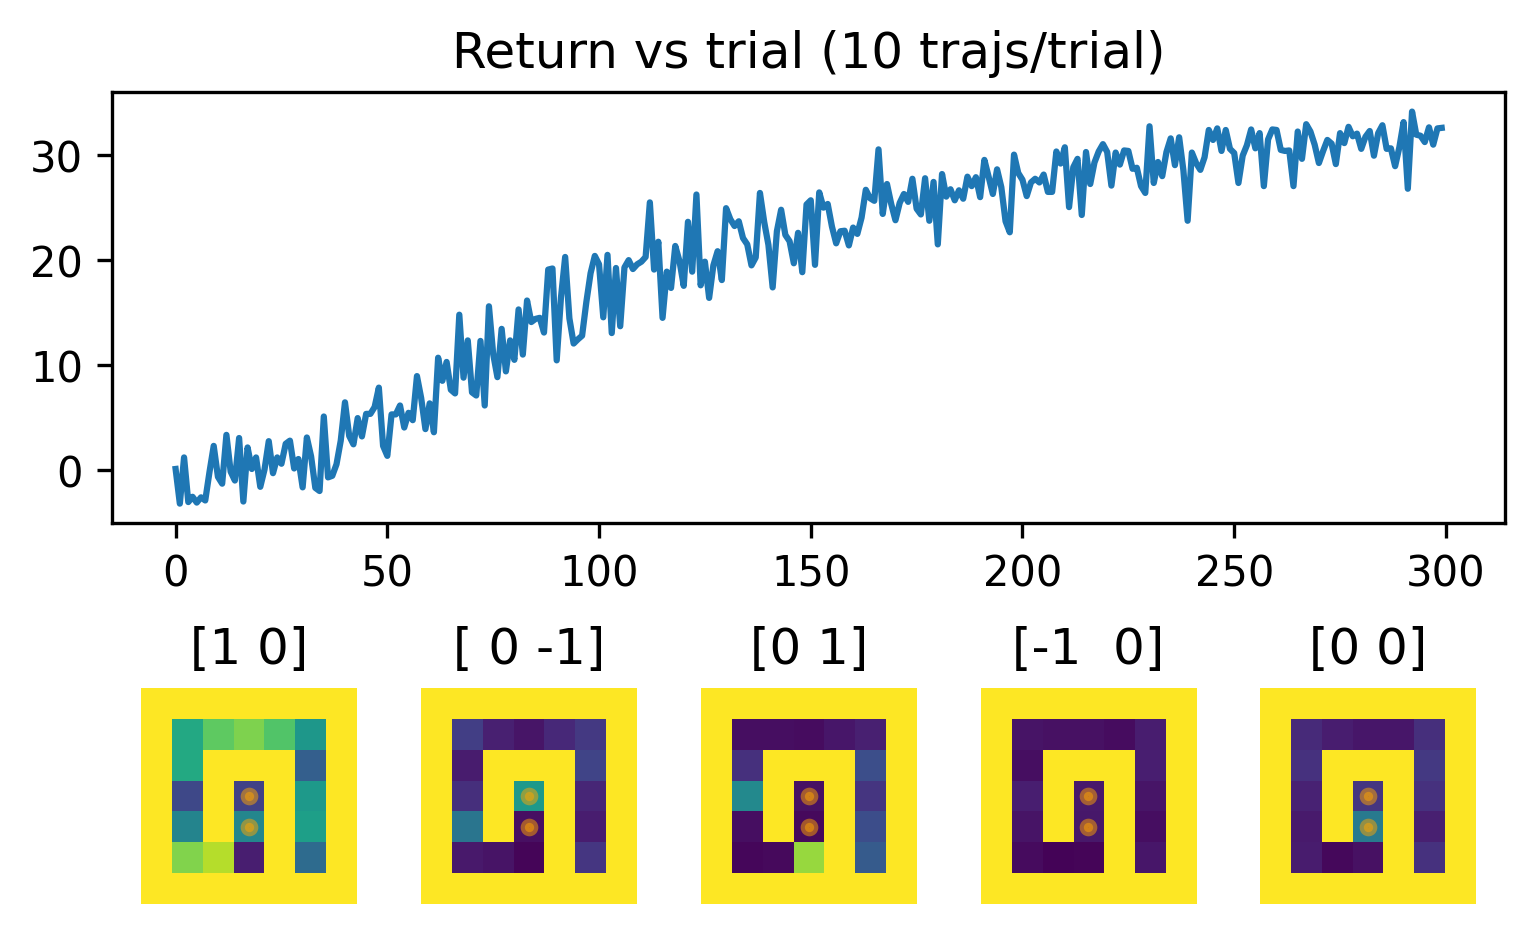

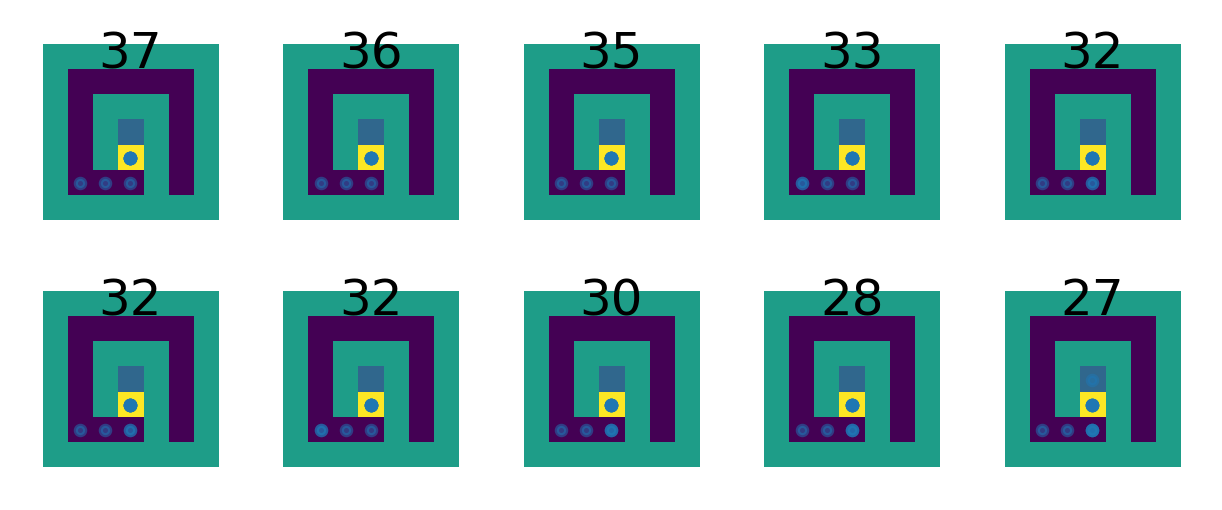

In [4]:
mymaze.run(ntrials=300) # you can run this repeatedly to get more training!

In [32]:
# run this to refresh the network (re-initialize)
# you can then continue with training, using the same maze
# and other parameters
mymaze.create_network()
mymaze.compile_net(eta=0.00005,try_adam=True)
# only if you want to reset the plotted Returns:
mymaze.refresh_returns()

# Now: for arbitrary mazes (here: treasures remain, are not deleted)

Also this works nicely!

In [110]:
# initialize the network and everything else!
# first run of this may take up to 10sec (compiling network, I suppose)
mymaze=MazeRL(M=15,eta=0.0002,num_chests=4,delete_treasure=False,
          single_maze=False,batchsize=10,test_batchsize=5,
          nsteps=15,try_adam=True,
          choose_random_positions_for_single_maze=False, 
          kernel_size=3, num_channels=10, punish_wall_hit=0.1,
             train_for_action_map=True)

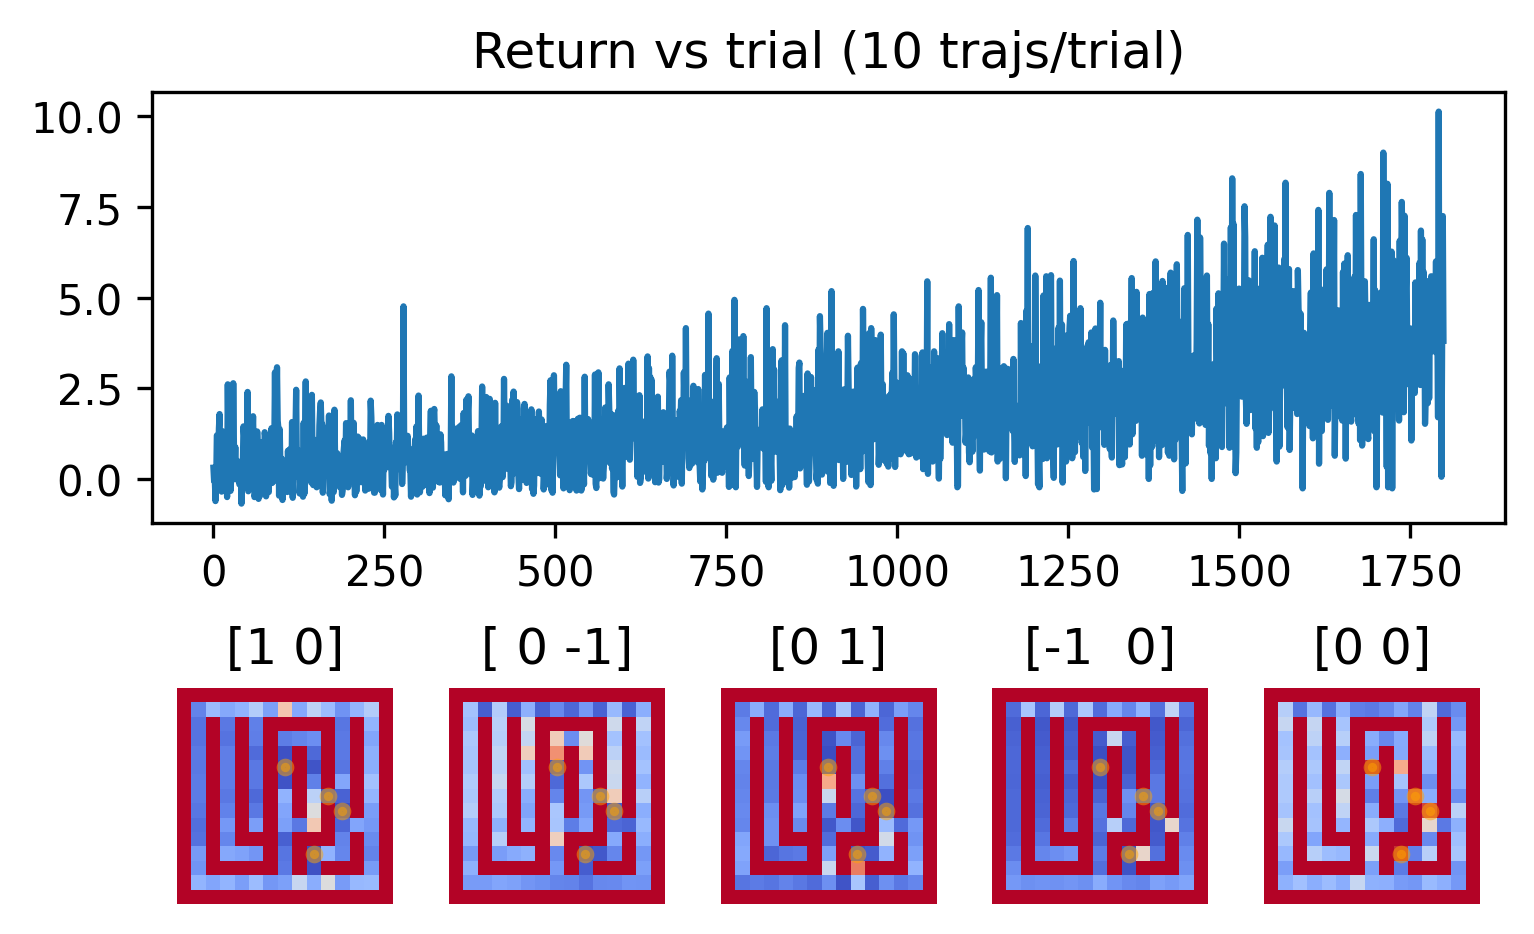

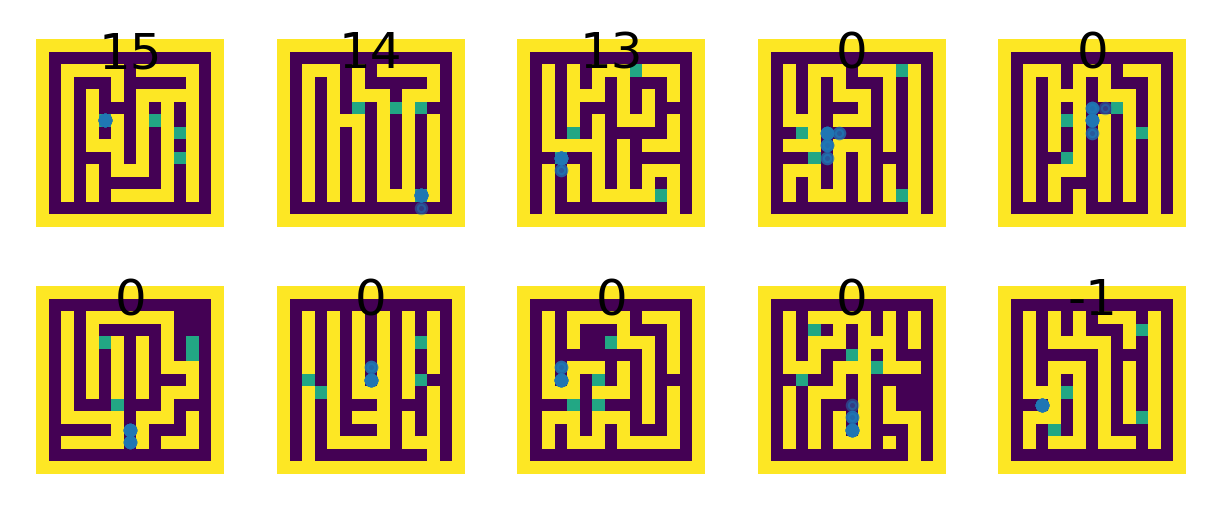

In [116]:
mymaze.run(ntrials=300,P_cmap='coolwarm')

Little change: change the number of time steps (while keeping the existing network!)

In [117]:
mymaze.setup(M=15,num_chests=4,delete_treasure=False,
          single_maze=False,batchsize=10,test_batchsize=5,
          nsteps=30,
          choose_random_positions_for_single_maze=False, 
          punish_wall_hit=0.1,
             train_for_action_map=True)

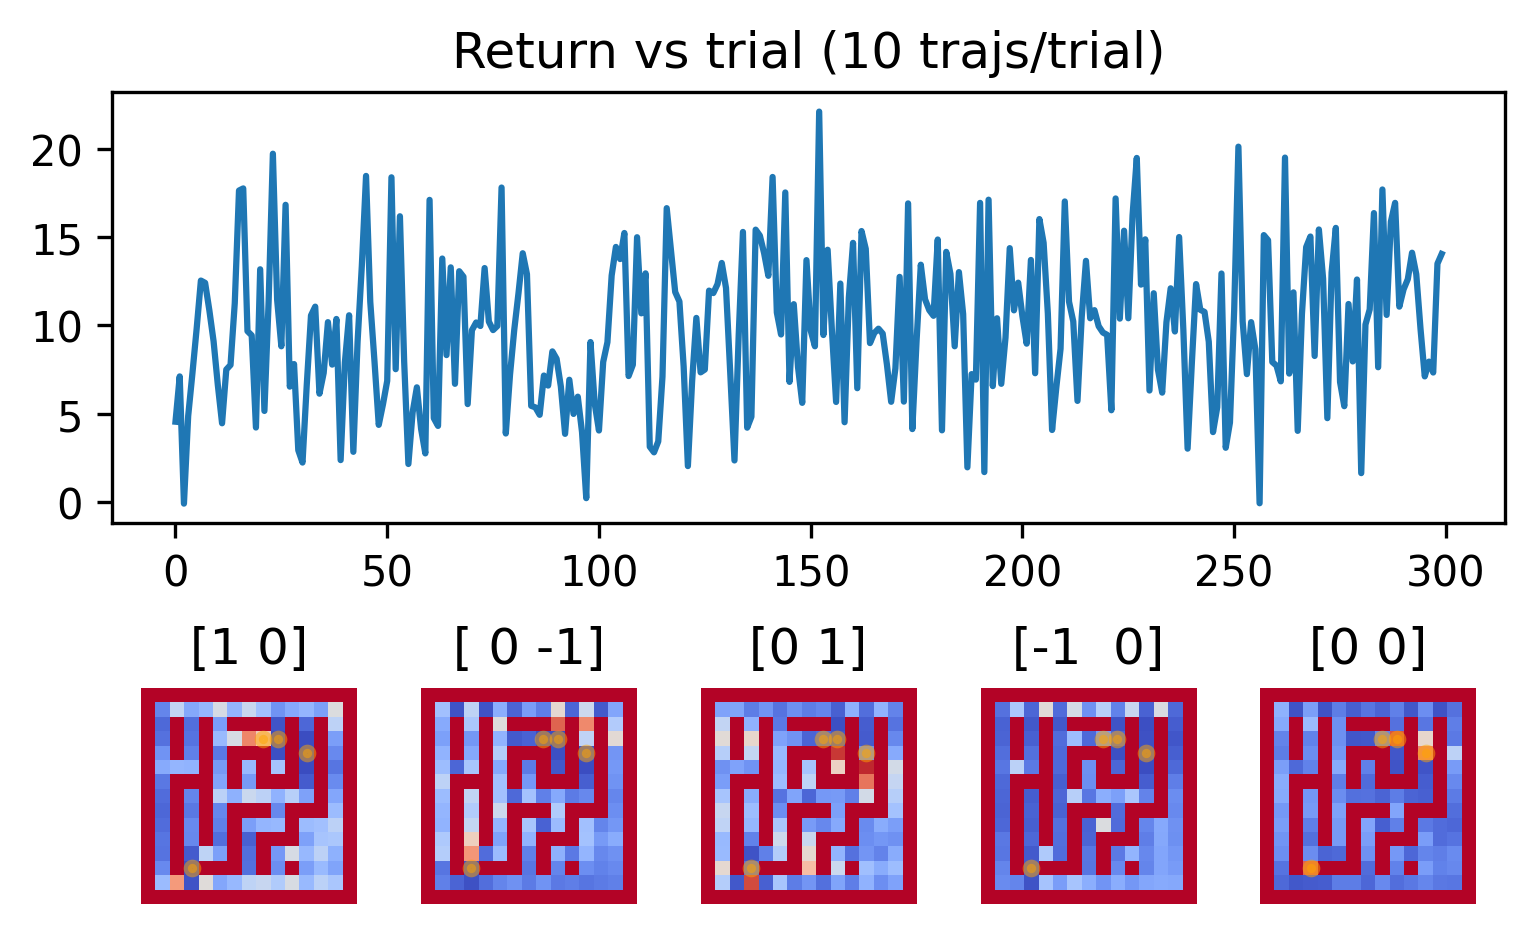

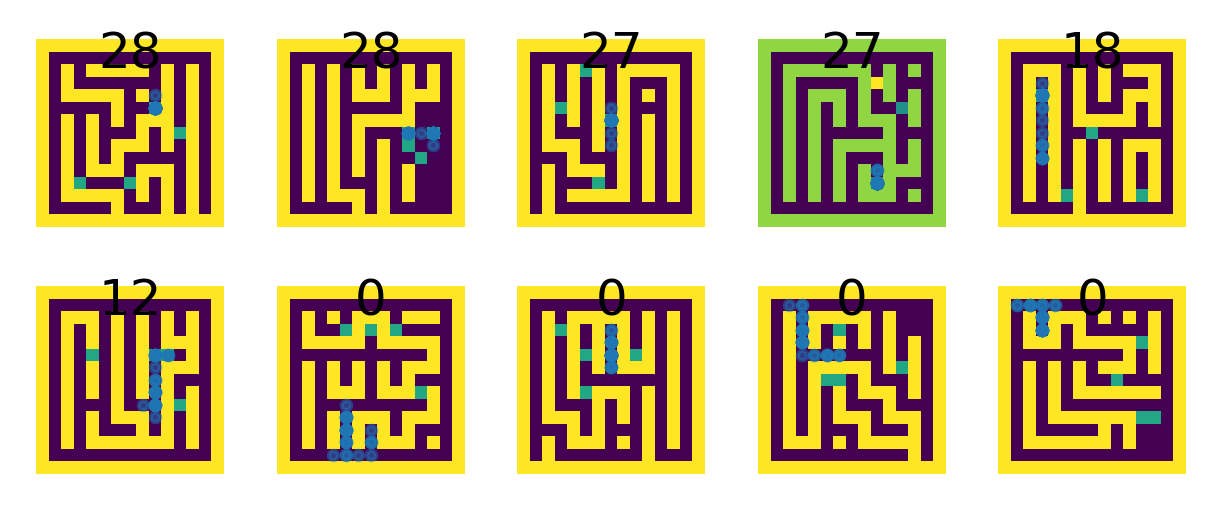

In [118]:
mymaze.run(ntrials=300,P_cmap='coolwarm')

Now attempt to delete treasures, keep training on same network: does not succeed

In [119]:
mymaze.setup(M=15,num_chests=8,delete_treasure=True,
          single_maze=False,batchsize=10,test_batchsize=5,
          nsteps=30,
          choose_random_positions_for_single_maze=False, 
          punish_wall_hit=0.1,
             train_for_action_map=True)

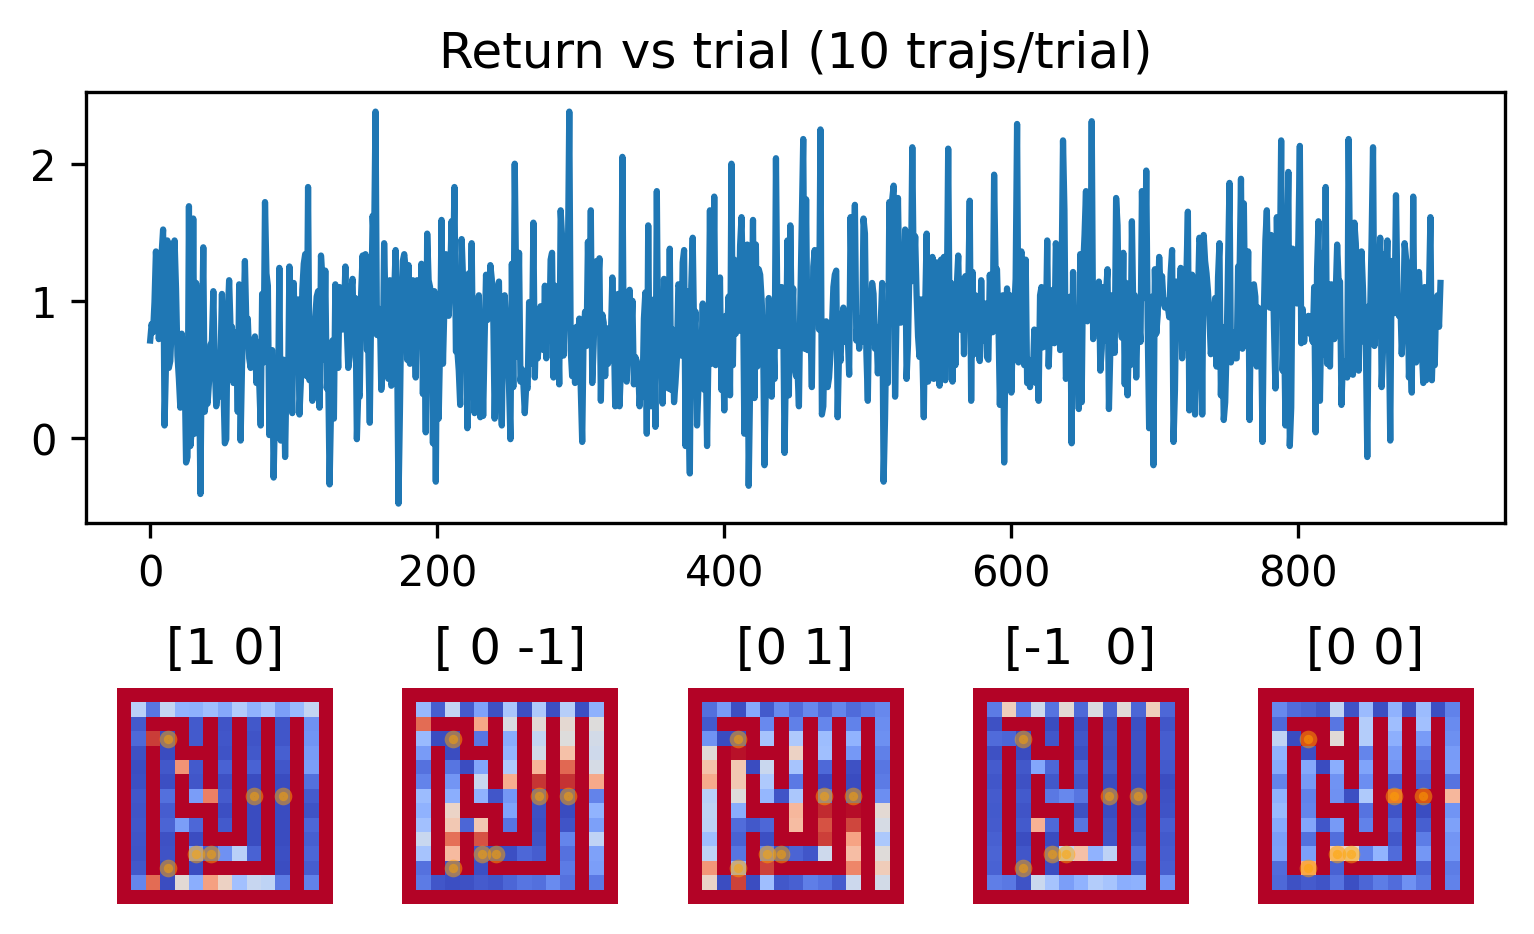

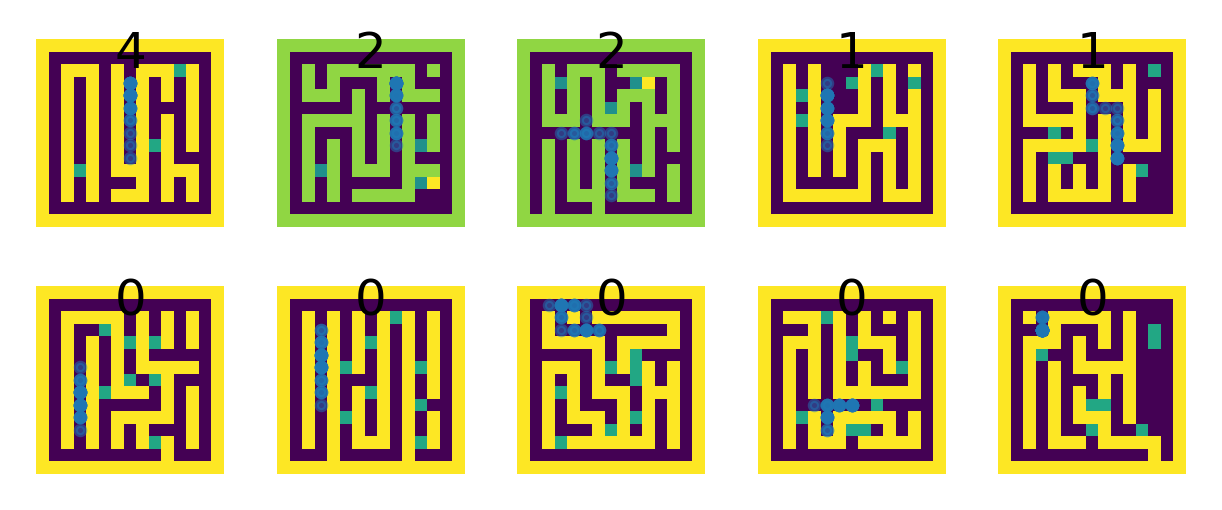

In [122]:
mymaze.run(ntrials=300,P_cmap='coolwarm')

# The really hard case: arbitrary mazes, delete treasures

Here in principle it should learn to keep wandering through the whole maze to pick up all the treasure chests!

In [8]:
# initialize the network and everything else!
# first run of this may take up to 10sec (compiling network, I suppose)
mymaze=MazeRL(M=15,eta=0.0002,num_chests=10,delete_treasure=True,
          single_maze=False,batchsize=40,test_batchsize=5,
          nsteps=40,try_adam=True,
          choose_random_positions_for_single_maze=False, 
          kernel_size=3, num_channels=10, punish_wall_hit=0.0,
             train_for_action_map=True)

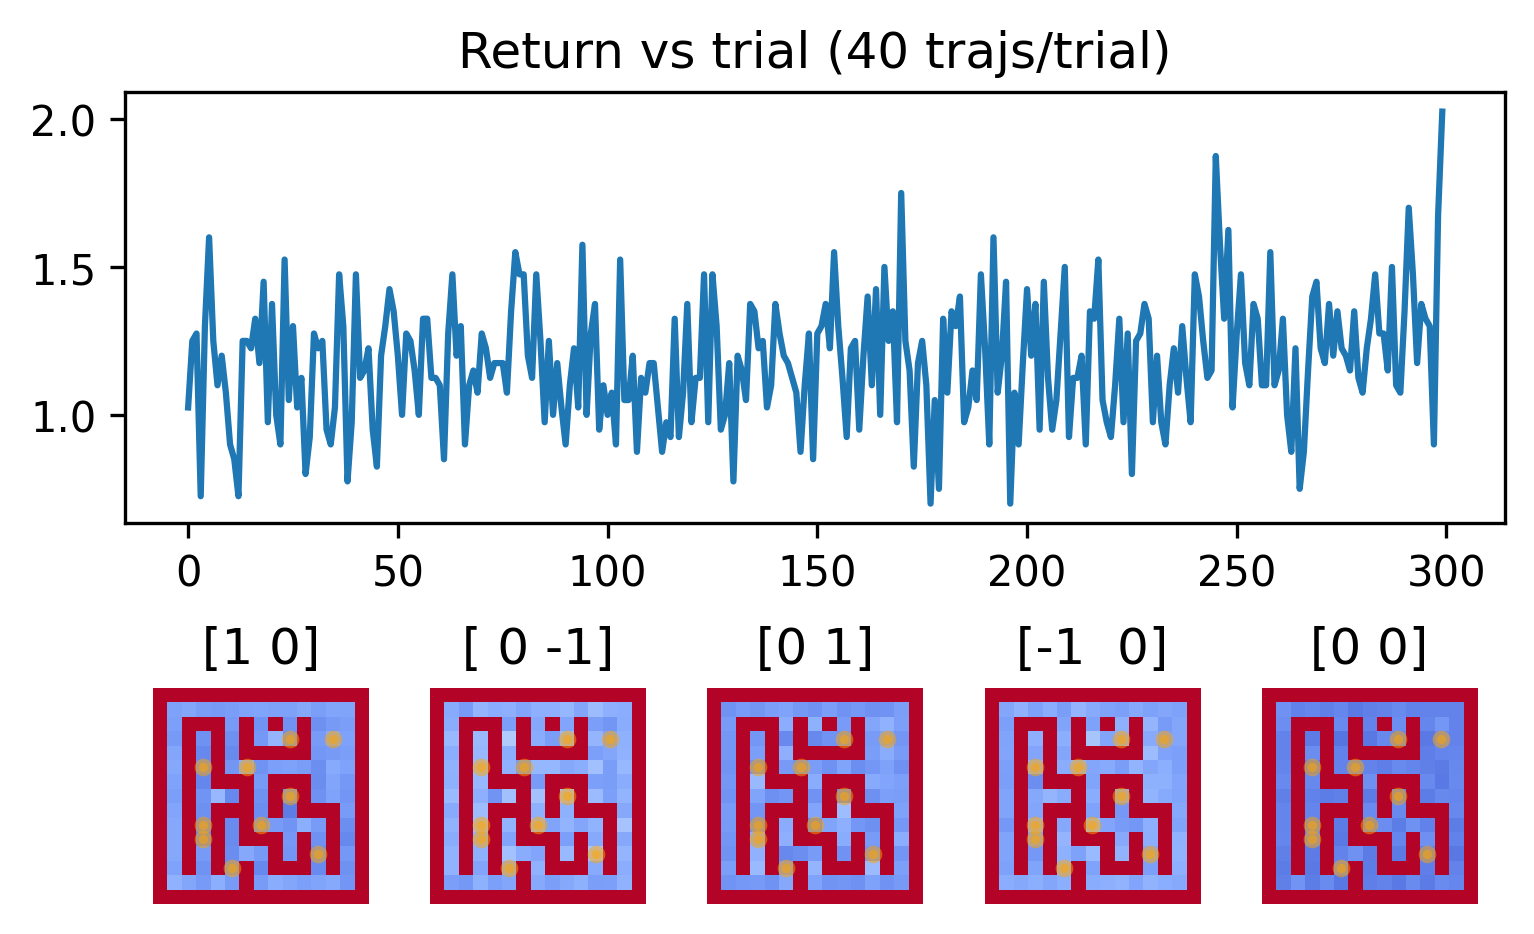

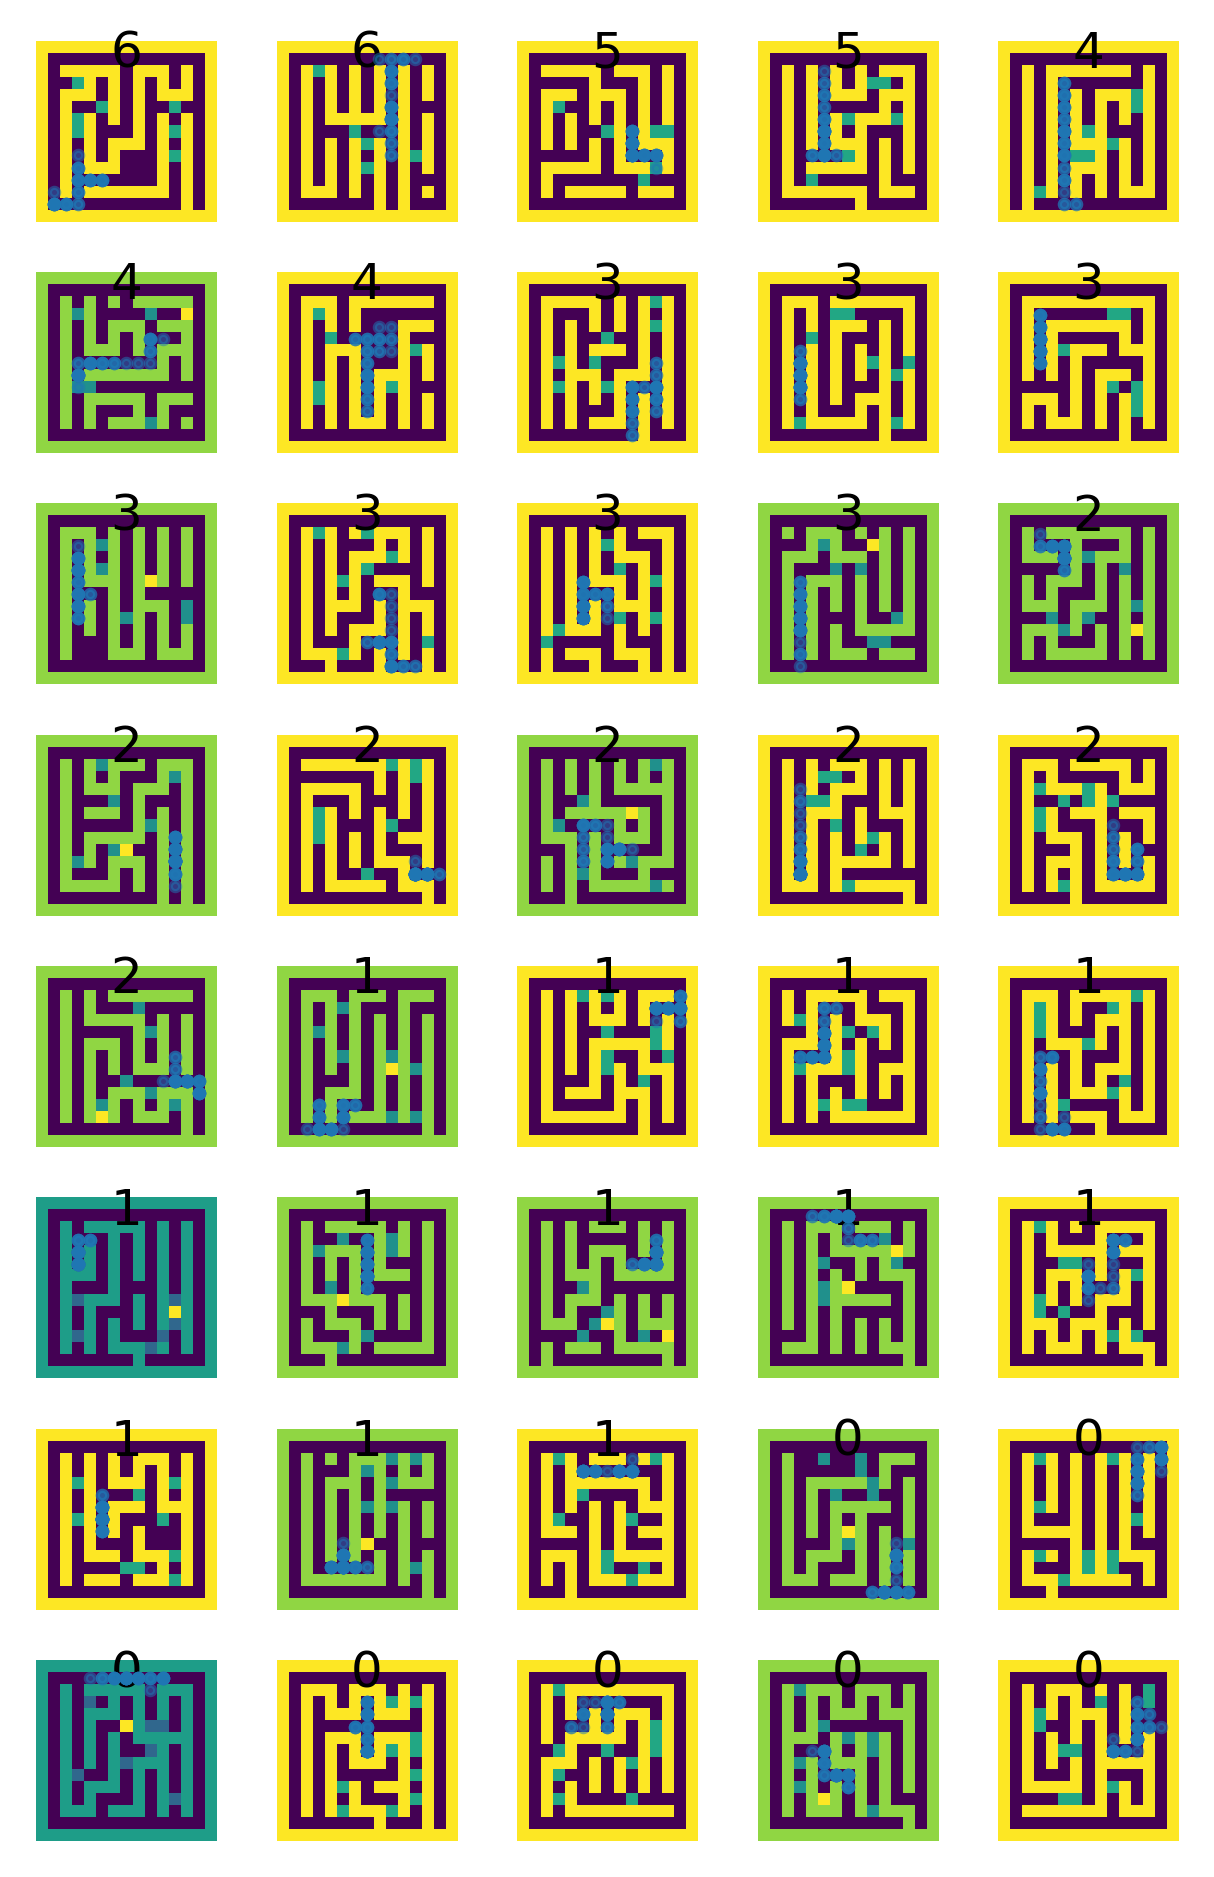

In [9]:
mymaze.run(ntrials=300,P_cmap='coolwarm')

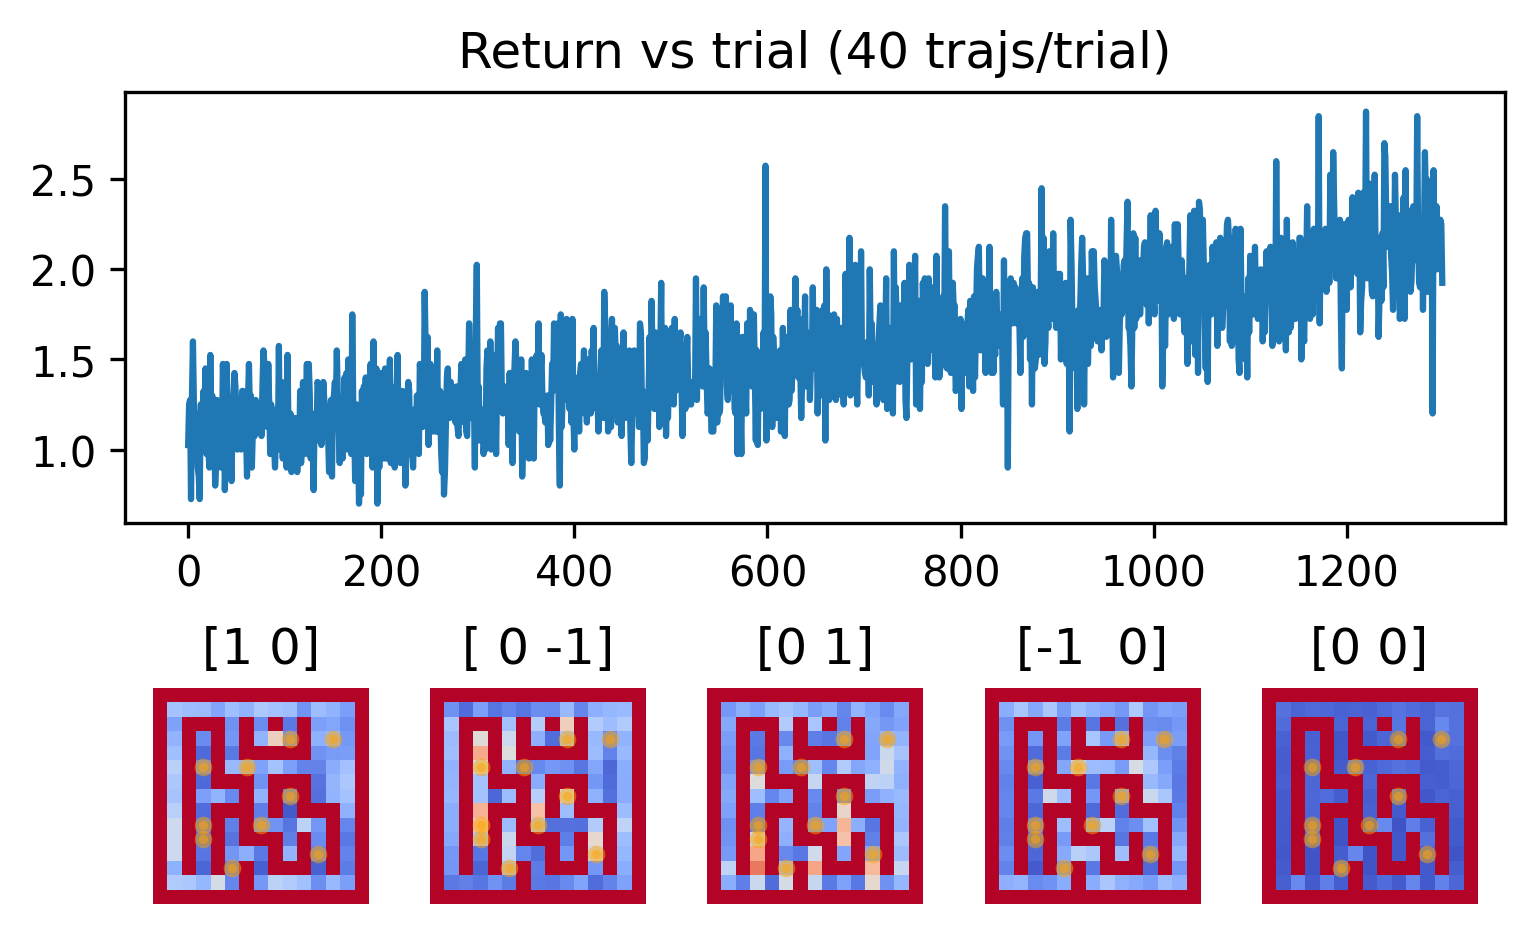

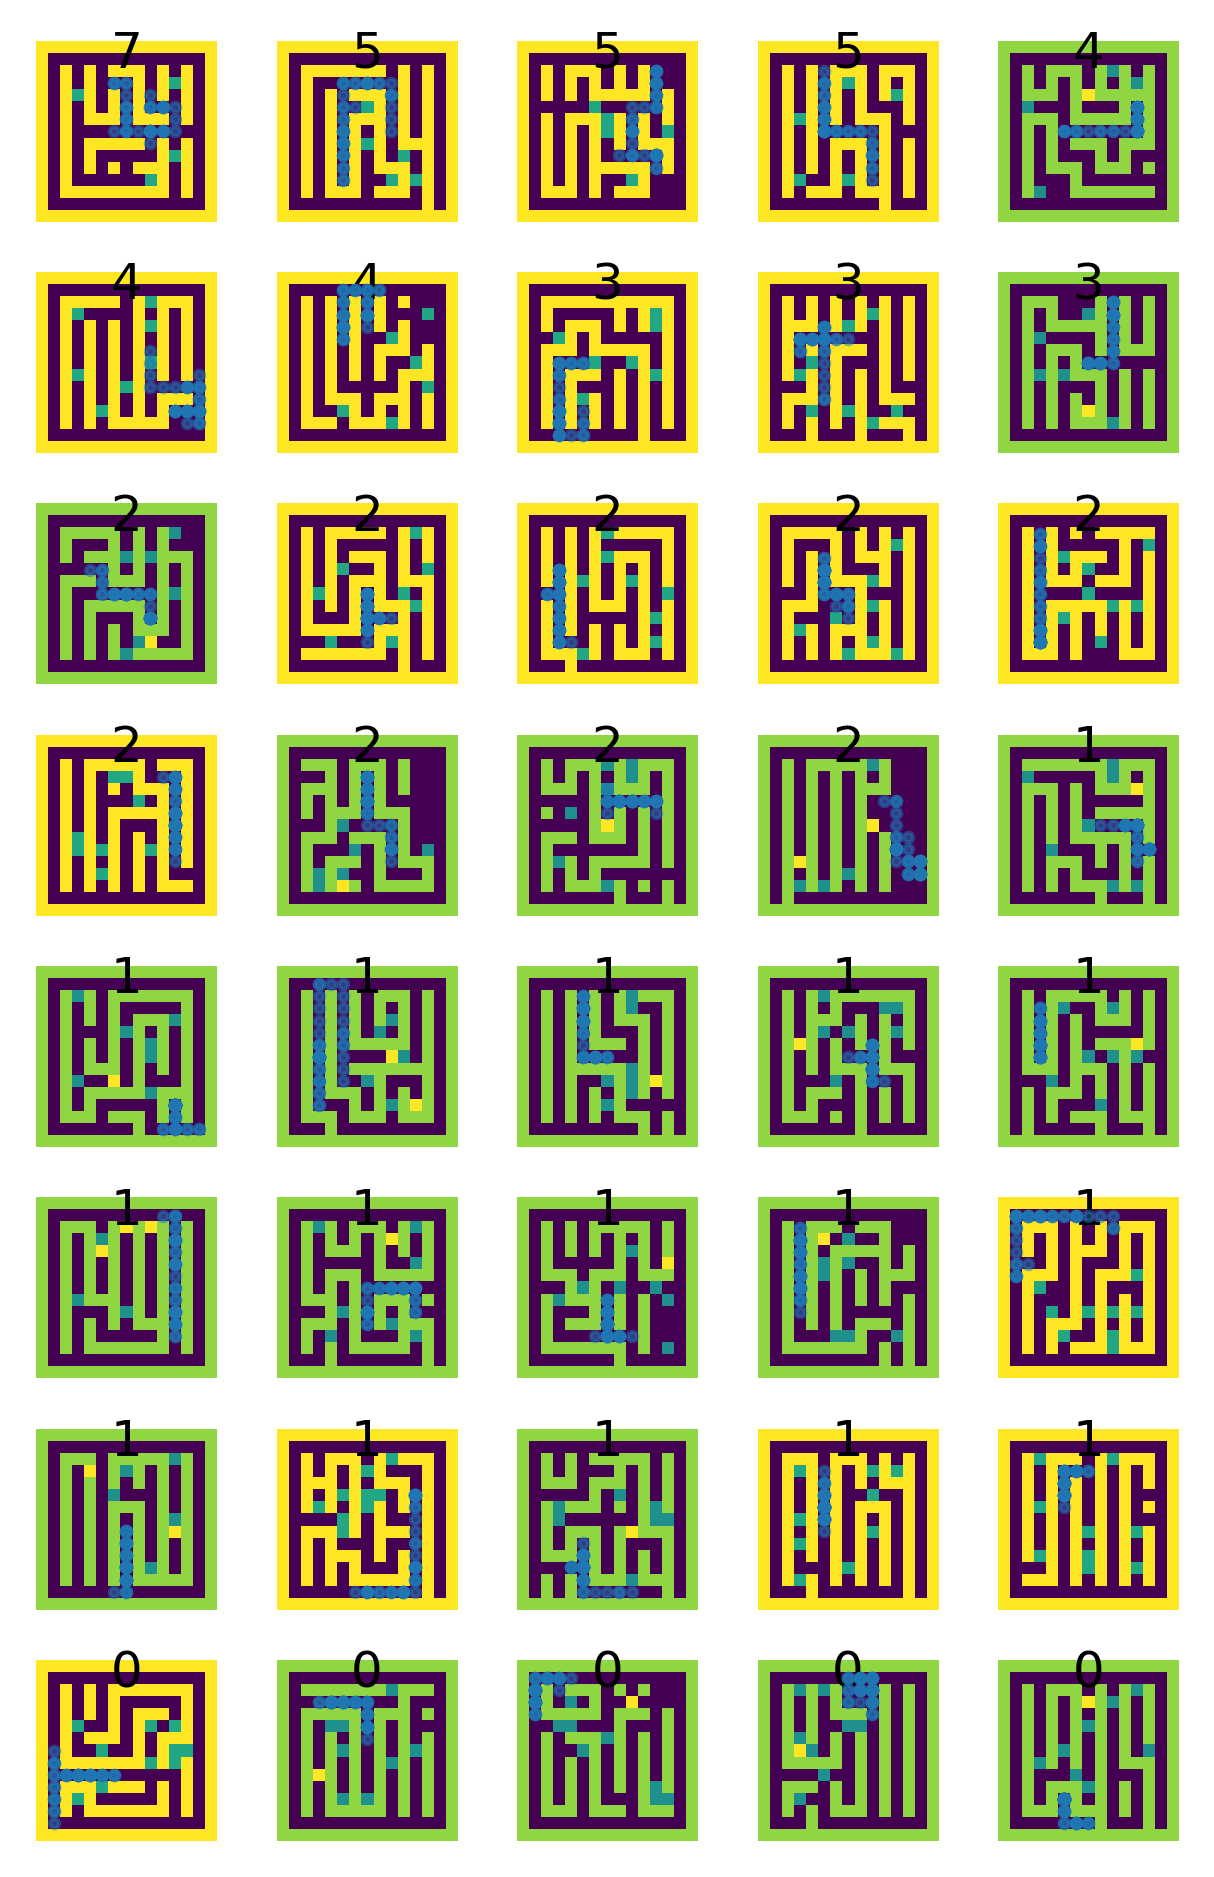

In [10]:
mymaze.run(ntrials=1000,P_cmap='coolwarm')